In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, BitsAndBytesConfig, TrainingArguments, Trainer, get_linear_schedule_with_warmup
from datasets import load_dataset, concatenate_datasets, Dataset

from peft import get_peft_config, get_peft_model, prepare_model_for_kbit_training, PeftConfig, PeftModel

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

from tqdm import tqdm

import evaluate 

In [2]:
def check_gpu_memory():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        for gpu_id in range(num_gpus):
            free_mem, total_mem = torch.cuda.mem_get_info(gpu_id)
            gpu_properties = torch.cuda.get_device_properties(gpu_id)
            print(f"GPU {gpu_id}: {gpu_properties.name}")
            print(f"   Total Memory: {total_mem / (1024 ** 3):.2f} GB")
            print(f"   Free Memory: {free_mem / (1024 ** 3):.2f} GB")
            print(f"   Allocated Memory : {torch.cuda.memory_allocated(gpu_id) / (1024 ** 3):.2f} GB")
            print(f"   Reserved Memory : {torch.cuda.memory_reserved(gpu_id) / (1024 ** 3):.2f} GB")
    else:
        print("No GPU available.")

check_gpu_memory()

GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
   Total Memory: 4.00 GB
   Free Memory: 3.23 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


In [3]:
def get_artifical_data_for_label(label:str):
    label_dict = {
        "rrms": "relapsing_remitting_multiple_sclerosis",
        "ppms": "primary_progressive_multiple_sclerosis",
        "spms": "secondary_progressive_multiple_sclerosis"
    }
    generated_data = pd.read_csv(paths.DATA_PATH_PREPROCESSED/f'ms-diag/artificial_{label}.csv')
    generated_data["labels"] = label_dict[label]
    generated_data = generated_data[["0", "labels"]].rename(columns = {"0":"text"})

    return generated_data

def get_artifical_data_all():
    artifical_data = []
    for label in ["rrms", "ppms", "spms"]:
        try: 
            artifical_data.append(get_artifical_data_for_label(label))
        except:
            print(f"Could not find data for {label}")
    artifical_data = pd.concat(artifical_data)
    artifical_data = Dataset.from_pandas(artifical_data).remove_columns('__index_level_0__')
    return artifical_data

In [4]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
df["train"] = concatenate_datasets([get_artifical_data_all(), df["train"]])

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {'primary_progressive_multiple_sclerosis': 0,
            'relapsing_remitting_multiple_sclerosis': 1,
            'secondary_progressive_multiple_sclerosis': 2}
id2label = {v:k for k,v in label2id.items()}

Could not find data for rrms


In [56]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'rid', 'date'],
        num_rows: 383
    })
    validation: Dataset({
        features: ['rid', 'date', 'labels', 'text'],
        num_rows: 14
    })
    test: Dataset({
        features: ['rid', 'date', 'labels', 'text'],
        num_rows: 59
    })
})

In [13]:
print("Memory before Model is loaded:\n")
check_gpu_memory()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels, load_in_4bit=True)
print("Memory after Model is loaded:\n")
check_gpu_memory()
model = prepare_model_for_kbit_training(model)

Memory before Model is loaded:

GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
   Total Memory: 4.00 GB
   Free Memory: 0.00 GB
   Allocated Memory : 1.36 GB
   Reserved Memory : 3.70 GB


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/models/medbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memory after Model is loaded:

GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
   Total Memory: 4.00 GB
   Free Memory: 1.27 GB
   Allocated Memory : 1.46 GB
   Reserved Memory : 1.92 GB


In [14]:
# For quantized training need to prepare model
config = {
    "peft_type": "PREFIX_TUNING",
    "task_type": "SEQ_CLS",
    "inference_mode": False,
    "num_virtual_tokens": 0,
    "token_dim": model.config.hidden_size,
    "num_transformer_submodules": 1,
    "num_attention_heads": model.config.num_attention_heads,
    "num_layers": model.config.num_hidden_layers,
    "encoder_hidden_size": 128,
    "prefix_projection": True,
}
peft_config = get_peft_config(config)
print(peft_config)
model = get_peft_model(model, peft_config)

PrefixTuningConfig(peft_type=<PeftType.PREFIX_TUNING: 'PREFIX_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, num_virtual_tokens=0, token_dim=768, num_transformer_submodules=1, num_attention_heads=8, num_layers=12, encoder_hidden_size=128, prefix_projection=True)


In [15]:
# Trainable parameters
model.print_trainable_parameters()
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, "Shape:",param.shape)

trainable params: 2,478,467 || all params: 111,562,118 || trainable%: 2.2216026769947126
base_model.classifier.modules_to_save.default.weight Shape: torch.Size([3, 768])
base_model.classifier.modules_to_save.default.bias Shape: torch.Size([3])
prompt_encoder.default.embedding.weight Shape: torch.Size([0, 768])
prompt_encoder.default.transform.0.weight Shape: torch.Size([128, 768])
prompt_encoder.default.transform.0.bias Shape: torch.Size([128])
prompt_encoder.default.transform.2.weight Shape: torch.Size([18432, 128])
prompt_encoder.default.transform.2.bias Shape: torch.Size([18432])


In [16]:
# Prepare dataset
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


def tokenize_function(examples):
    # We need space for the prefixes, so if the sequence is longer/equal than the max model length we need to truncate to tokenizer.model_max_length - peft_config.num_virtual_tokens
    outputs = tokenizer(examples["text"], truncation=True, max_length=128)
    outputs["labels"] = [label2id[label] for label in examples["labels"]]
    return outputs

encoded_dataset = df.map(tokenize_function, batched=True, remove_columns=["text", "rid", "date"])

# Small train dataset with balanced classes
rmms_id = label2id['relapsing_remitting_multiple_sclerosis']
small_train_dataset = concatenate_datasets([encoded_dataset['train'].filter(lambda example: example['labels'] != rmms_id), encoded_dataset['train'].filter(lambda example: example['labels'] == rmms_id).shuffle(seed=42).select(range(10))])

In [17]:
# Hyperparameters
train_batch_size = 32
eval_batch_size = 16
learning_rate = 1e-2
num_epochs = 4
gradient_accumulation_steps = 1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
# Prepare data collator
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

# DataLoaders creation
train_dataloader = DataLoader(
    encoded_dataset["train"], shuffle=True, collate_fn=data_collator, batch_size=train_batch_size,
)
eval_dataloader = DataLoader(
    encoded_dataset["validation"], shuffle=False, collate_fn=data_collator, batch_size=eval_batch_size
)

In [19]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

# Loss
# Class weights
power = 1
class_weights = [1/np.log(len(encoded_dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(encoded_dataset['train']['labels'])]
class_weights = [weight**power for weight in class_weights]
class_weights = torch.tensor(class_weights, dtype=model.dtype).detach().to(device)


loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

In [20]:
# Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        batch.to(device)
        outputs = model(**batch)
        logits = outputs.logits
        # loss = loss_fun(logits, batch['labels'])
        loss = outputs.loss
        total_loss += loss.detach().float()

        loss = loss / gradient_accumulation_steps
        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    train_epoch_loss = total_loss / len(train_dataloader)
    print(f"{epoch=}: {train_epoch_loss=} {eval_epoch_loss=}")

  0%|          | 0/12 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


epoch=0: train_epoch_loss=tensor(1.2849, device='cuda:0') eval_epoch_loss=tensor(0.9211, device='cuda:0')


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


epoch=1: train_epoch_loss=tensor(0.8014, device='cuda:0') eval_epoch_loss=tensor(0.6723, device='cuda:0')


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


epoch=2: train_epoch_loss=tensor(0.6545, device='cuda:0') eval_epoch_loss=tensor(0.7073, device='cuda:0')


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch=3: train_epoch_loss=tensor(0.5512, device='cuda:0') eval_epoch_loss=tensor(0.7401, device='cuda:0')


In [65]:
# Save model
# model.save_pretrained(paths.MODEL_PATH/'peft_medbert_msdiag')

# Load model
# config = PeftConfig.from_pretrained(paths.MODEL_PATH/'peft_medbert_msdiag')
loaded_model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels, torch_dtype=torch.bfloat16)
loaded_model = PeftModel.from_pretrained(model = loaded_model, model_id = paths.MODEL_PATH/'peft_medbert_msdiag')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/models/medbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
# Inference on test set
loaded_model.to(device)
loaded_model.eval()
test_dataloader = DataLoader(
    encoded_dataset["test"], shuffle=False, collate_fn=data_collator, batch_size=eval_batch_size
)
test_preds_loaded = []
for step, batch in enumerate(tqdm(test_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        logits = loaded_model(**batch).logits.to(torch.float32)
    test_preds_loaded.append(logits.detach().cpu().numpy())

test_preds_loaded = np.concatenate(test_preds_loaded)
test_preds_loaded = np.argmax(test_preds_loaded, axis=1)

100%|██████████| 4/4 [00:00<00:00, 17.97it/s]


In [67]:
test_preds_loaded

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [68]:
# Inference on test set
model.eval()
test_dataloader = DataLoader(
    encoded_dataset["test"], shuffle=False, collate_fn=data_collator, batch_size=eval_batch_size
)
test_preds = []
for step, batch in enumerate(tqdm(test_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        logits = model(**batch).logits.to(torch.float32)
    test_preds.append(logits.detach().cpu().numpy())

test_preds = np.concatenate(test_preds)
test_preds = np.argmax(test_preds, axis=1)

100%|██████████| 4/4 [00:00<00:00, 22.40it/s]


In [69]:
test_preds

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [74]:
test_preds_loaded == test_preds

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [70]:
# Sklearn F1, precision, recall, accuracy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
print(f"Accuracy: {accuracy_score(encoded_dataset['test']['labels'], test_preds)}")
print(f"Precision: {precision_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")
print(f"Recall: {recall_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")
print(f"F1: {f1_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")

Accuracy: 0.8983050847457628
Precision: 0.764957264957265
Recall: 0.6260683760683761
F1: 0.601994301994302


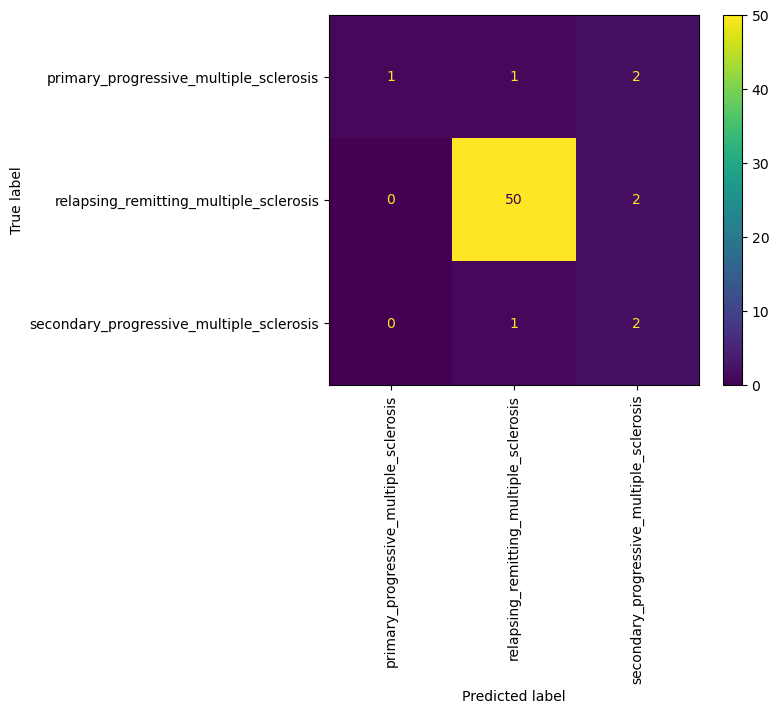

In [71]:
# ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(encoded_dataset["test"]["labels"], test_preds, display_labels=label2id, xticks_rotation="vertical")

class PromptLearningConfig(PeftConfig):
    """
    This is the base configuration class to store the configuration of [`PrefixTuning`], [`PromptEncoder`], or
    [`PromptTuning`].

    Args:
        num_virtual_tokens (`int`): The number of virtual tokens to use.
        token_dim (`int`): The hidden embedding dimension of the base transformer model.
        num_transformer_submodules (`int`): The number of transformer submodules in the base transformer model.
        num_attention_heads (`int`): The number of attention heads in the base transformer model.
        num_layers (`int`): The number of layers in the base transformer model.
    """

    num_virtual_tokens: int = field(default=None, metadata={"help": "Number of virtual tokens"})
    token_dim: int = field(
        default=None, metadata={"help": "The hidden embedding dimension of the base transformer model"}
    )
    num_transformer_submodules: Optional[int] = field(
        default=None, metadata={"help": "Number of transformer submodules"}
    )
    num_attention_heads: Optional[int] = field(default=None, metadata={"help": "Number of attention heads"})
    num_layers: Optional[int] = field(default=None, metadata={"help": "Number of transformer layers"})

configuratio interpretation:
- num_virtual_tokens: number of prefix tokens to append to (each layer?)
- num_transformer_submodules: 1 or 2? for decoder/encoder? or is it number of layers? I think decoder encoder architecture because if it is not set, they set it to 1 except in a Seq2Seq task. And they create embeddings for the virtual tokens only once for each submodule?
- num_layers: to how many layers we should add the prefix tuning?
- The peft model will automatically try to infer all the model specification from model.config in the `get_peft_model()` call. It will also automatically construct the PEFT Model class from the task type: return MODEL_TYPE_TO_PEFT_MODEL_MAPPING[peft_config.task_type](model, peft_config, adapter_name=adapter_name)
- you can add multiple adapters (must be all of same peft type though) to a mode each with their own configurations. You must give them unique names, otherwise gives name "default". Each prompt encoding and the whole process will be done for every single adapter I think. It first prepares the peft config by matching non specified elements with the model config. It then sets up the prompt encoder (_set_up_prompt_encoder(adapter_name)) using the created config for the adapter
- If specification is PROMPT_TUNING we just create a trainable word embeddings matrix. By inserting an init text you can initialize the embedding from the base tokenizer and base model. 
- I think the prompt_token ids are initialized separately from the existing ids for the tokenizer. Because we have a different embedding matrix we can initialize from 0 to 19 say and then put it through, then concatenate the weights again to the embeddings of the base model without the virtual tokens. As they don't have any meaning and we will always have the same order of them (first will be virtual token 0, then 1 etc.) we also don't really neew to match them in the forward pass order will always be same.

``` python
if config.num_transformer_submodules is None:
            config.num_transformer_submodules = 2 if config.task_type == TaskType.SEQ_2_SEQ_LM else 1
total_virtual_tokens = config.num_virtual_tokens * config.num_transformer_submodules
```

```
def _prepare_prompt_learning_config(peft_config, model_config):
    if peft_config.num_layers is None:
        if "num_hidden_layers" in model_config:
            num_layers = model_config["num_hidden_layers"]
        elif "num_layers" in model_config:
            num_layers = model_config["num_layers"]
        elif "n_layer" in model_config:
            num_layers = model_config["n_layer"]
        else:
            raise ValueError("Please specify `num_layers` in `peft_config`")
        peft_config.num_layers = num_layers

    if peft_config.token_dim is None:
        if "hidden_size" in model_config:
            token_dim = model_config["hidden_size"]
        elif "n_embd" in model_config:
            token_dim = model_config["n_embd"]
        elif "d_model" in model_config:
            token_dim = model_config["d_model"]
        else:
            raise ValueError("Please specify `token_dim` in `peft_config`")
        peft_config.token_dim = token_dim

    if peft_config.num_attention_heads is None:
        if "num_attention_heads" in model_config:
            num_attention_heads = model_config["num_attention_heads"]
        elif "n_head" in model_config:
            num_attention_heads = model_config["n_head"]
        elif "num_heads" in model_config:
            num_attention_heads = model_config["num_heads"]
        elif "encoder_attention_heads" in model_config:
            num_attention_heads = model_config["encoder_attention_heads"]
        else:
            raise ValueError("Please specify `num_attention_heads` in `peft_config`")
        peft_config.num_attention_heads = num_attention_heads

    if getattr(peft_config, "encoder_hidden_size", None) is None:
        setattr(peft_config, "encoder_hidden_size", peft_config.token_dim)

    return peft_config
```

prefix tuning forward:
- The prefixes are inserted into the model using the past_key_values which is the cached keys and values of the whole sequence before the current token in the autoregressive generation procedure. Instead of computing these keys and values with a model forward pass, we simply compute them directly with our MLP model. This is also why we need the number of attention heads (as we need a pair for every head).
- The prompt encoder returns num_layers * 2 * token_dim past key values, so for every layer a key and value. Reading this one could think only "one token" (one key value pair) is generated. But later this is reshaped into:

past_key_values = past_key_values.view(
                batch_size,
                peft_config.num_virtual_tokens,
                peft_config.num_layers * 2,
                peft_config.num_attention_heads,
                peft_config.token_dim // peft_config.num_attention_heads,
            )

so we again have num_virtual_tokens as a dimension. This matrix is then permuted and split which I don't know the specifics of but it ensures that it is in the correct format.

def _prefix_tuning_forward(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        batch_size = _get_batch_size(input_ids, inputs_embeds)
        past_key_values = self.get_prompt(batch_size)
        fwd_params = list(inspect.signature(self.base_model.forward).parameters.keys())
        kwargs.update(
            {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "inputs_embeds": inputs_embeds,
                "output_attentions": output_attentions,
                "output_hidden_states": output_hidden_states,
                "return_dict": return_dict,
                "past_key_values": past_key_values,
            }
        )
        if "past_key_values" in fwd_params:
            return self.base_model(labels=labels, **kwargs)
        else:
            transformer_backbone_name = self.base_model.get_submodule(self.transformer_backbone_name)
            fwd_params = list(inspect.signature(transformer_backbone_name.forward).parameters.keys())
            if "past_key_values" not in fwd_params:
                raise ValueError("Model does not support past key values which are required for prefix tuning.")
            outputs = transformer_backbone_name(**kwargs)
            pooled_output = outputs[1] if len(outputs) > 1 else outputs[0]
            if "dropout" in [name for name, _ in list(self.base_model.named_children())]:
                pooled_output = self.base_model.dropout(pooled_output)
            logits = self.base_model.get_submodule(self.cls_layer_name)(pooled_output)

            loss = None
            if labels is not None:
                if self.config.problem_type is None:
                    if self.base_model.num_labels == 1:
                        self.config.problem_type = "regression"
                    elif self.base_model.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                        self.config.problem_type = "single_label_classification"
                    else:
                        self.config.problem_type = "multi_label_classification"

                if self.config.problem_type == "regression":
                    loss_fct = MSELoss()
                    if self.base_model.num_labels == 1:
                        loss = loss_fct(logits.squeeze(), labels.squeeze())
                    else:
                        loss = loss_fct(logits, labels)
                elif self.config.problem_type == "single_label_classification":
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.base_model.num_labels), labels.view(-1))
                elif self.config.problem_type == "multi_label_classification":
                    loss_fct = BCEWithLogitsLoss()
                    loss = loss_fct(logits, labels)
            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )

def get_prompt(self, batch_size: int, task_ids: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Returns the virtual prompts to use for Peft. Only applicable when using a prompt learning method.
        """
        peft_config = self.active_peft_config
        prompt_encoder = self.prompt_encoder[self.active_adapter]
        prompt_tokens = (
            self.prompt_tokens[self.active_adapter]
            .unsqueeze(0)
            .expand(batch_size, -1)
            .to(prompt_encoder.embedding.weight.device)
        )
        if peft_config.peft_type == PeftType.PREFIX_TUNING:
            prompt_tokens = prompt_tokens[:, : peft_config.num_virtual_tokens]
            if peft_config.inference_mode:
                past_key_values = prompt_encoder.embedding.weight.repeat(batch_size, 1, 1)
            else:
                past_key_values = prompt_encoder(prompt_tokens)
            if self.base_model_torch_dtype is not None:
                past_key_values = past_key_values.to(self.base_model_torch_dtype)
            past_key_values = past_key_values.view(
                batch_size,
                peft_config.num_virtual_tokens,
                peft_config.num_layers * 2,
                peft_config.num_attention_heads,
                peft_config.token_dim // peft_config.num_attention_heads,
            )
            if peft_config.num_transformer_submodules == 2:
                past_key_values = torch.cat([past_key_values, past_key_values], dim=2)
            past_key_values = past_key_values.permute([2, 0, 3, 1, 4]).split(
                peft_config.num_transformer_submodules * 2
            )
            if TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING.get(self.config.model_type, None) is not None:
                post_process_fn = TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING[self.config.model_type]
                past_key_values = post_process_fn(past_key_values)
            return past_key_values
        else:
            if peft_config.peft_type == PeftType.MULTITASK_PROMPT_TUNING:
                prompts = prompt_encoder(prompt_tokens, task_ids)
            else:
                if peft_config.inference_mode:
                    prompts = prompt_encoder.embedding.weight.repeat(batch_size, 1, 1)
                else:
                    prompts = prompt_encoder(prompt_tokens)
            return prompts


class PrefixEncoder(torch.nn.Module):
    r"""
    The `torch.nn` model to encode the prefix.

    Args:
        config ([`PrefixTuningConfig`]): The configuration of the prefix encoder.

    Example:

    ```py
    >>> from peft import PrefixEncoder, PrefixTuningConfig

    >>> config = PrefixTuningConfig(
    ...     peft_type="PREFIX_TUNING",
    ...     task_type="SEQ_2_SEQ_LM",
    ...     num_virtual_tokens=20,
    ...     token_dim=768,
    ...     num_transformer_submodules=1,
    ...     num_attention_heads=12,
    ...     num_layers=12,
    ...     encoder_hidden_size=768,
    ... )
    >>> prefix_encoder = PrefixEncoder(config)
    ```

    **Attributes**:
        - **embedding** (`torch.nn.Embedding`) -- The embedding layer of the prefix encoder.
        - **transform** (`torch.nn.Sequential`) -- The two-layer MLP to transform the prefix embeddings if
          `prefix_projection` is `True`.
        - **prefix_projection** (`bool`) -- Whether to project the prefix embeddings.

    Input shape: (`batch_size`, `num_virtual_tokens`)

    Output shape: (`batch_size`, `num_virtual_tokens`, `2*layers*hidden`)
    """

    def __init__(self, config):
        super().__init__()
        self.prefix_projection = config.prefix_projection
        token_dim = config.token_dim
        num_layers = config.num_layers
        encoder_hidden_size = config.encoder_hidden_size
        num_virtual_tokens = config.num_virtual_tokens
        if self.prefix_projection and not config.inference_mode:
            # Use a two-layer MLP to encode the prefix
            self.embedding = torch.nn.Embedding(num_virtual_tokens, token_dim)
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(token_dim, encoder_hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(encoder_hidden_size, num_layers * 2 * token_dim),
            )
        else:
            self.embedding = torch.nn.Embedding(num_virtual_tokens, num_layers * 2 * token_dim)

    def forward(self, prefix: torch.Tensor):
        if self.prefix_projection:
            prefix_tokens = self.embedding(prefix)
            past_key_values = self.transform(prefix_tokens)
        else:
            past_key_values = self.embedding(prefix)
        return past_key_values